# Fashion Mnist - Fine-Tuning DARTS

## Import Libraries

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from utils import mnist_reader # Download from Fashion Mnist repo

## Download and Load Data

In [2]:
# Download Data if needed
# !wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
# !wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
# !wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
# !wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

In [3]:
# Load Data
# Change Data folder respectively
data_folder = "./data"

train_images, train_labels = mnist_reader.load_mnist(data_folder, "train")
test_images, test_labels = mnist_reader.load_mnist(data_folder, "t10k")

train_images = train_images.reshape(-1, 28,28, 1)
test_images = test_images.reshape(-1, 28,28, 1)

## Basic Data Visualization

In [4]:
def visualize_data(data, target, title="Train Data Visualization"):
  labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
  # Set the figure size
  fig = plt.figure(figsize=(10,10))
  # Show only the first 50 pictures
  plt.suptitle(title)
  # Inex range
  index_l = random.sample(range(0, len(target)), 30)
  for i in range(25):
      plt.subplot(5,5, i+1)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(data[index_l[i]], cmap=plt.cm.binary)
      plt.xlabel(labels[target[index_l[i]]])
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])

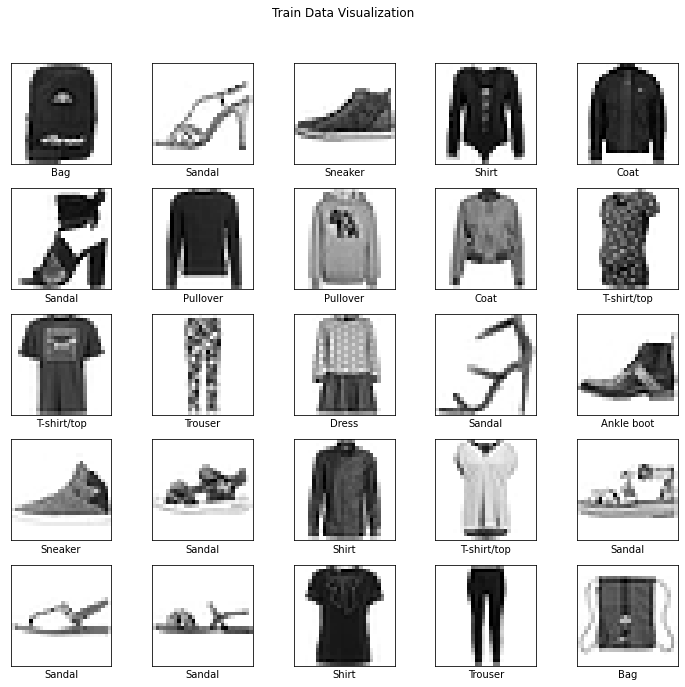

In [5]:
visualize_data(train_images, train_labels)

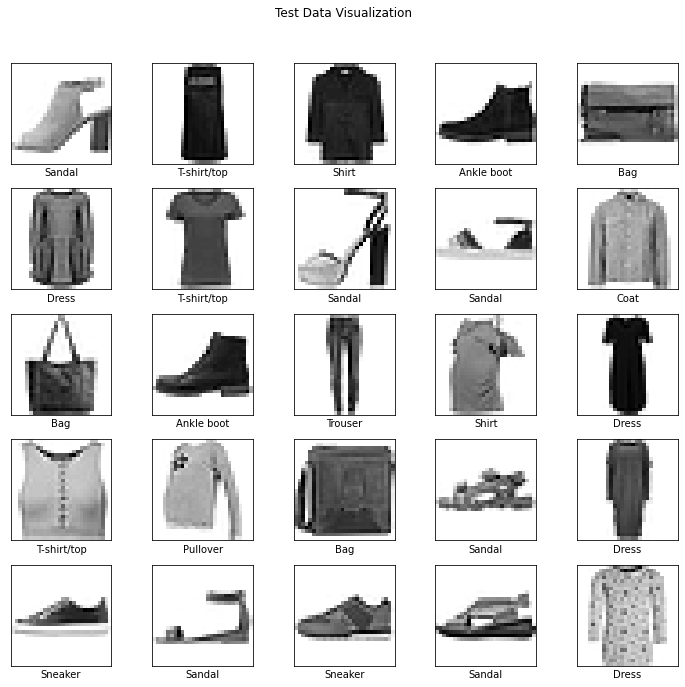

In [6]:
visualize_data(test_images, test_labels, "Test Data Visualization")

## Convert Target Labels to One Hot Encoding 

In [7]:
from sklearn.preprocessing import OneHotEncoder

In [8]:
encoder = OneHotEncoder(sparse=False)
train_labels_oh = encoder.fit_transform(train_labels.reshape(-1, 1))
test_labels_oh = encoder.transform(test_labels.reshape(-1, 1))

In [9]:
train_labels_oh

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
train_labels_oh.shape

(60000, 10)

## Build Model

In [12]:
def get_model(input_shape=(28, 28, 1)):
    input = tf.keras.layers.Input(shape=input_shape)

    conv2d_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", name="Conv2D_1")(input)
    batch_norm_1 = tf.keras.layers.BatchNormalization(name="Batch_Normalization_1")(conv2d_1)
    relu_1 = tf.keras.layers.Activation(activation="relu", name="ReLU_1")(batch_norm_1)

    conv2d_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", name="Conv2D_2")(relu_1)
    batch_norm_2 = tf.keras.layers.BatchNormalization(name="Batch_Normalization_2")(conv2d_2)
    relu_2 = tf.keras.layers.Activation(activation="relu", name="ReLU_2")(batch_norm_2)

    conv2d_3 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", name="Conv2D_3")(relu_2)
    batch_norm_3 = tf.keras.layers.BatchNormalization(name="Batch_Normalization_3")(conv2d_3)

    attention_1 = tf.keras.layers.Attention(name="Attention_1")([batch_norm_2, batch_norm_3])
    attention_2 = tf.keras.layers.Attention(name="Attention_2")([batch_norm_3, attention_1])
    attention_3 = tf.keras.layers.Attention(name="Attention_3")([attention_1, attention_2])
    attention_4 = tf.keras.layers.Attention(name="Attention_4")([attention_2, attention_3])

    pooling = tf.keras.layers.MaxPooling2D(pool_size=(3,3), name="MaxPooling2D")(attention_4)
    flatten = tf.keras.layers.Flatten(name="Flatten")(pooling)

    x = tf.keras.layers.Dense(128)(flatten)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Dense(32)(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    outputs = tf.keras.layers.Dense(10, activation="softmax")(x)

    model = tf.keras.Model(inputs=input, outputs=outputs)
    model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics="acc")
    
    return model

In [13]:
model = get_model()

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 Conv2D_1 (Conv2D)              (None, 28, 28, 32)   320         ['input_1[0][0]']                
                                                                                                  
 Batch_Normalization_1 (BatchNo  (None, 28, 28, 32)  128         ['Conv2D_1[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 ReLU_1 (Activation)            (None, 28, 28, 32)   0           ['Batch_Normalization_1[0][0]

## Model Training

In [15]:
# Possbile Callbacks
# model check pointer
# early stopping
# learning rate scheduler *optional

# Build Callbacks
MC = tf.keras.callbacks.ModelCheckpoint(
    "models/finetune_darts.h5",
    monitor = "val_loss",
    save_best_only = True,
    save_weights_only = False
)

ES = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=4
)

In [17]:
# If kernel crashes or you get an resource exhauseted error, reduce batch size, always use powers of 2 eg: 32, 62, 128...
history = model.fit(train_images, train_labels_oh, epochs=1000, batch_size=1024,validation_split=0.1, callbacks=[MC, ES])

Epoch 1/1000
53/53 [==============================] - 11s 193ms/step - loss: 2.6743 - acc: 0.5986 - val_loss: 2.0704 - val_acc: 0.6065
Epoch 2/1000
53/53 [==============================] - 10s 182ms/step - loss: 0.7319 - acc: 0.7655 - val_loss: 0.8425 - val_acc: 0.7655
Epoch 3/1000
53/53 [==============================] - 10s 183ms/step - loss: 0.6288 - acc: 0.7964 - val_loss: 0.6892 - val_acc: 0.7913
Epoch 4/1000
53/53 [==============================] - 10s 183ms/step - loss: 0.5694 - acc: 0.8141 - val_loss: 0.5252 - val_acc: 0.8238
Epoch 5/1000
53/53 [==============================] - 10s 184ms/step - loss: 0.5200 - acc: 0.8266 - val_loss: 0.4321 - val_acc: 0.8495
Epoch 6/1000
53/53 [==============================] - 10s 184ms/step - loss: 0.4748 - acc: 0.8391 - val_loss: 0.3925 - val_acc: 0.8570
Epoch 7/1000
53/53 [==============================] - 10s 184ms/step - loss: 0.4642 - acc: 0.8442 - val_loss: 0.3862 - val_acc: 0.8603
Epoch 8/1000
53/53 [==============================] - 1

## Training Assesment

In [31]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

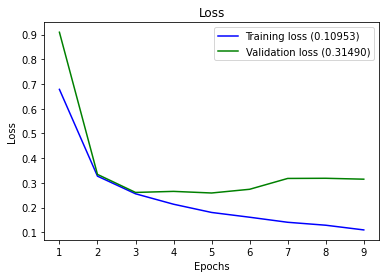

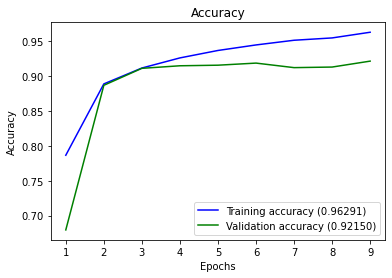

In [32]:
# Plot Loss and Accuracy of Training History
plot_history(history)

## Model Evaluation

In [11]:
# load best model
best_model = tf.keras.models.load_model("./models/finetune_darts.h5")

In [12]:
best_model.evaluate(test_images, test_labels_oh)

313/313 [==============================] - 7s 4ms/step - loss: 0.3150 - acc: 0.8889


[0.3149874806404114, 0.8888999819755554]

In [13]:
predictions = best_model.predict(test_images)
# Get the Single labels from predction instead of an array of probabilities
predictions = np.argmax(predictions, axis=1)

In [14]:
# Accuracy on the Test Set
test_acc = accuracy_score(test_labels, predictions)
print(f"Test Accuracy is {test_acc*100}%")

Test Accuracy is 88.89%


In [15]:
# Classification Report
print(classification_report(test_labels, predictions, target_names=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']))

              precision    recall  f1-score   support

 T-shirt/top       0.80      0.87      0.84      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.78      0.86      0.82      1000
       Dress       0.87      0.94      0.90      1000
        Coat       0.80      0.83      0.81      1000
      Sandal       0.98      0.96      0.97      1000
       Shirt       0.81      0.55      0.65      1000
     Sneaker       0.93      0.97      0.95      1000
         Bag       0.96      0.97      0.97      1000
  Ankle boot       0.97      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [16]:
def plot_confusion_matrix(y_test, y_pred):
    labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = (20, 10))
    cm = pd.DataFrame(cm , index = [i for i in labels] , columns = [i for i in labels])
    sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
    plt.title('Fashion Mnist Confusion Matrix', size=20)
    plt.xlabel('Predicted Labels', size=14)
    plt.ylabel('Actual Labels', size=14)
    plt.show()

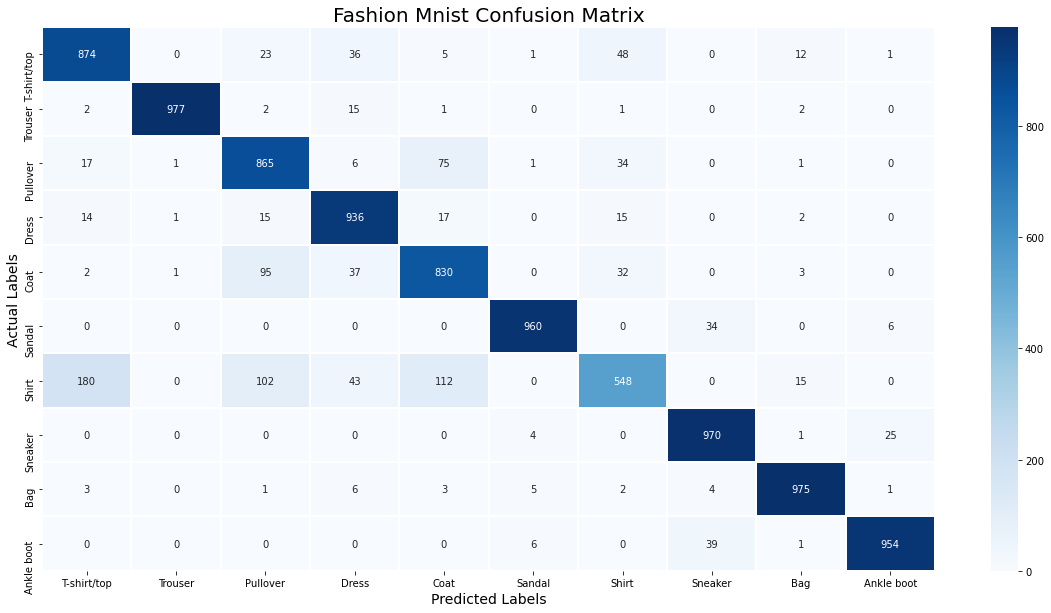

In [17]:
plot_confusion_matrix(test_labels, predictions)

## Summary

- Test Accuracy is 88.89%
- Model F1 Score is 89%
- Model Precision is 89%
- Model Recall is 89%
- Best Perfoming Class is "Trouser"
- Worst Performing Class is "Shirt"
- Model only accpeted Images with 3 Channels, Image size was flexible

## Inference Speed

In [12]:
from tqdm import tqdm
import time

In [13]:
def get_inference_speed(model, data=test_images[:500]):
    #  GPU warm up
    model.predict(data)
    
    start_time = time.time()
    for i in tqdm(range(100)):
        model.predict(data)
    end_time = time.time()
    speed = (end_time - start_time) / (100 * len(data))
    return speed * 1000

In [14]:
get_inference_speed(best_model)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.39it/s]


0.27070037841796873